In [ ]:
# !pip install cartopy
# !pip install optuna

In [1]:
# import networkx as nx
import os
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2
from itertools import permutations
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import permutations
import random
import optuna
import json


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\elio\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\elio\anaconda3\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\elio\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\elio\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\elio\anaconda3\lib\site-packages\

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\elio\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\elio\anaconda3\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\elio\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\elio\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\elio\anaconda3\lib\site-packages\

AttributeError: _ARRAY_API not found

In [2]:
# load in data 
data_path = '../data/worldcities.csv'
df = pd.read_csv(data_path)

In [3]:
# Get the most populated cities
n_cities = 30
most_populated = df.nlargest(n_cities, columns=['population'])

In [4]:
# Get cities with latitude and longitude
cities = {
    city: (lat, lon)
    for city, lat, lon in zip(most_populated.city, most_populated.lat, most_populated.lng)
}

In [5]:
# cities dictionary with city names and population
cities_population = {
    city: population
    for city, population in zip(most_populated.city, most_populated.population)
}

# Find the city with the highest population as our start city
start_city = max(cities_population, key=cities_population.get)
print("Start City:", start_city)

Start City: Tokyo


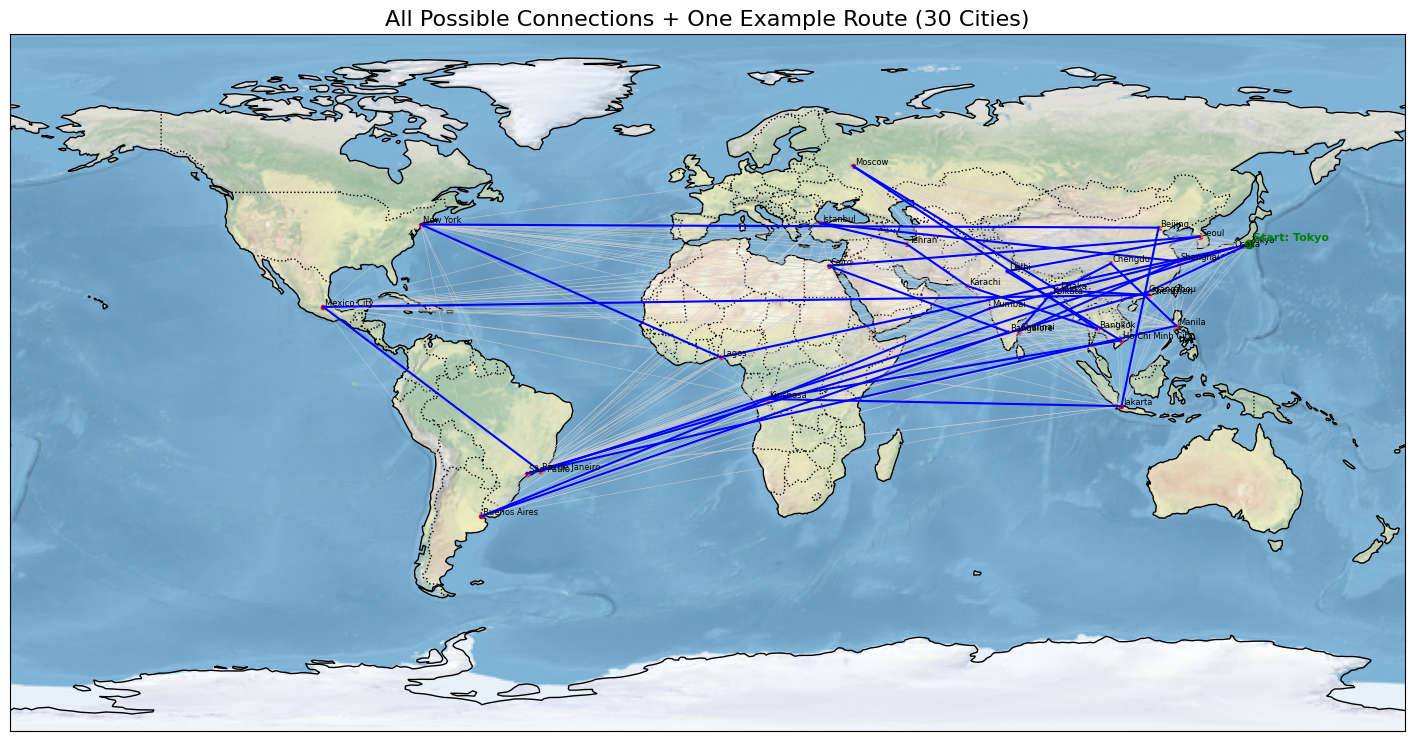

In [6]:
# set random seed to reproduce same results
random.seed(55)
np.random.seed(55)
rng = random.Random(55)

# Create an example route (first permutation)
cities_list = list(cities.keys())

# One random round-trip path
random_path = rng.sample(cities_list[1:], len(cities_list) - 1)
example_path = [cities_list[0], *random_path, cities_list[0]]

# Set up the map
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot cities
for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'ro', markersize=3, transform=ccrs.PlateCarree())
    ax.text(lon + 0.5, lat + 0.5, city, fontsize=6, transform=ccrs.PlateCarree())

# Plot all direct connections (fully connected graph)
for i in range(len(cities_list)):
    for j in range(i + 1, len(cities_list)):
        city1 = cities_list[i]
        city2 = cities_list[j]
        lat1, lon1 = cities[city1]
        lat2, lon2 = cities[city2]
        ax.plot([lon1, lon2], [lat1, lat2], color='lightgray', linewidth=0.3, transform=ccrs.PlateCarree())

# Overlay one example round-trip route
for city1, city2 in zip(example_path[:-1], example_path[1:]):
    lat1, lon1 = cities[city1]
    lat2, lon2 = cities[city2]
    ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=1.5, transform=ccrs.PlateCarree())

#  Highlight start/end city
lat0, lon0 = cities[start_city]
ax.plot(lon0, lat0, 'go', markersize=6, transform=ccrs.PlateCarree())
ax.text(lon0 + 1, lat0 + 1, f'Start: {start_city}', fontsize=8, fontweight='bold', color='green', transform=ccrs.PlateCarree())

# Plot
n_cities = len(cities_list)
plt.title(f"All Possible Connections + One Example Route ({n_cities} Cities)", fontsize=16)
plt.show()

In [7]:
class Graph:
    def __init__(self, cities, distances):
        self.nodes = cities
        self.distance = distances
        # initial pheromone intensity between all cities is set to 0.1
        self.intensity = {city: {other_city: 0.01 for other_city in cities} for city in cities}
        # indexation of the cities
        self.city_to_idx = {city: idx for idx, city in enumerate(cities)}
        # indices to cities
        self.idx_to_city = {idx: city for idx, city in enumerate(cities)}

   
   # get the distance between cities 
    def get_distance(self, city1, city2):
        return self.distance[(city1, city2)] if (city1, city2) in self.distance else self.distance[(city2, city1)]

    # get the pheromone intensity between cities
    def get_pheromone(self, city1, city2):
        return self.intensity[city1][city2]

    # update the pheromone intensity after a walk of an 'ant'
    def update_pheromone(self, city1, city2, delta):
        self.intensity[city1][city2] += delta
        # since we work with distance the cost will be the same in the opposite direction
        self.intensity[city2][city1] += delta

In [8]:
# Calculate distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# Create a distance matrix using lat/lon from cities
distance_matrix = {}

for i, city1 in enumerate(cities_list):
    lat1, lon1 = cities[city1]
    for j, city2 in enumerate(cities_list):
        if i < j:
            lat2, lon2 = cities[city2]
            dist = haversine(lat1, lon1, lat2, lon2)
            distance_matrix[(city1, city2)] = dist
            distance_matrix[(city2, city1)] = dist  # Since distance is bidirectional

In [9]:
# Function to calculate the cost of a route
def cycle_cost(g, cycle):
    total_length = 0
    for i in range(len(cycle) - 1):
        city1 = g.idx_to_city[cycle[i]]
        city2 = g.idx_to_city[cycle[i + 1]]
        total_length += g.get_distance(city1, city2)
    # Return to the source node
    city1 = g.idx_to_city[cycle[-1]]
    city2 = g.idx_to_city[cycle[0]]
    total_length += g.get_distance(city1, city2)
    return total_length

In [10]:
# Simulate movement of one ant
def traverse_graph(g, start_city, source_node=0, ALPHA=0.5, BETA=2, rng=None):
    # ALPHA = Influence of pheromone level (higher means more exploration of high pheromone paths)
    # BETA = Influence of distance (higher means more preference for shorter distances)
    
    if rng is None:
        rng = random 
        
    # Ensure the start city is always the same 
    if source_node is None:
        source_node = g.city_to_idx[start_city]
    
    # Visited array to keep track of which nodes (cities) have been visited
    visited = np.asarray([1 for _ in range(len(g.nodes))])
    visited[source_node] = 0
    cycle = [source_node]
    steps = 0
    current = source_node
    current_city = g.idx_to_city[current]
    
    # Loop until all cities are visited (except the starting city, which is visited once)
    while steps < len(g.nodes) - 1:
        jumps_neighbors = []
        jumps_values = []

        for node in range(len(g.nodes)):
            if visited[node] != 0:
                next_city = g.idx_to_city[node]
                
                # Calculate the pheromone level and distance-based probability for choosing this city
                pheromone_level = max(g.get_pheromone(current_city, next_city), 1e-5)
                v = (pheromone_level ** ALPHA) / (g.get_distance(current_city, next_city) ** BETA)
                jumps_neighbors.append(node)
                jumps_values.append(v)

        # Choose the next city based on the weighted probabilities
        next_node = rng.choices(jumps_neighbors, weights=jumps_values)[0]
        visited[next_node] = 0
        cycle.append(next_node)
        current = next_node
        current_city = g.idx_to_city[current]
        steps += 1
    
    # Calculate the cost of the path
    total_length = cycle_cost(g, cycle)
    
    # Assert that no cities are repeated in the cycle
    assert len(list(set(cycle))) == len(cycle)
    return cycle, total_length

In [11]:
# Simlate multiple ants moving
def ant_colony_optimization(g, alpha=0.9, beta=2, start_city=None, verbose=True, iterations=100, ants_per_iteration=50, q=10, degradation_factor=0.9,
                            use_inertia=False, patience=100, visualize=True, rng=None):
    
    
    # initialize start city
    if start_city is None:
        start_city = list(g.nodes)[0]
    
    best_cycle = None
    best_length = float('inf')
    no_improvement_count = 0

    # after x runs the pheromones will be shaken up so we do not get stuck at a local optimum
    if use_inertia:
        old_best = None
        inertia = 0
        patience = 50

    # Convert the start city to its corresponding index
    start_idx = g.city_to_idx[start_city]
    
    last_best_length = float('inf')
    last_improvement_iteration = -1
    
    for iteration in range(iterations):
        cycles = [traverse_graph(g,start_city=start_idx, ALPHA=alpha, BETA=beta, rng=rng) for _ in range(ants_per_iteration)]
        # sort the cycle cost, short first
        cycles.sort(key=lambda x: x[1])
        # keep only the 50 shortest cycles to assign pheromones
        cycles = cycles[:ants_per_iteration // 2]

        # preserve the best cycle
        if best_cycle:
            cycles.append((best_cycle, best_length))
            if use_inertia:
                old_best = best_length
                
        # Update pheromones based on the cycles chosen by the ants
        for cycle, total_length in cycles:
            if total_length < best_length:
                best_length = total_length
                best_cycle = cycle
                no_improvement_count = 0  # Reset no improvement counter
            else:
                no_improvement_count += 1
                
            # Calculate the amount of pheromone to deposit
            delta = q / total_length
            for i in range(len(cycle) - 1):
                g.update_pheromone(g.idx_to_city[cycle[i]], g.idx_to_city[cycle[i + 1]], delta)
            g.update_pheromone(g.idx_to_city[cycle[-1]], g.idx_to_city[cycle[0]], delta)


            
        # Pheromone decay (evaporation) to reduce the intensity of pheromones over time
        for city1 in g.nodes:
            for city2 in g.nodes:
                if city1 != city2:
                    g.intensity[city1][city2] *= degradation_factor

        if use_inertia and best_cycle:
            # If no improvement in the best solution, apply inertia
            if old_best == best_length:
                inertia += 1
            else:
                inertia = 0
            
            # If no improvement after a certain number of iterations, apply a shake to the pheromones
            if inertia > patience:
                mean_pheromone = np.mean([pheromone for row in g.intensity.values() for pheromone in row.values()])
                for city1 in g.nodes:
                    for city2 in g.nodes:
                        g.intensity[city1][city2] += mean_pheromone
          
        if best_length < last_best_length:
            last_best_length = best_length
            last_improvement_iteration = iteration
            
        # Visualise         
        if visualize and iteration % 10 == 0 and best_cycle and last_improvement_iteration >= iteration - 10:
            draw_best_path(g, best_cycle, iteration)     
                
    return best_cycle, best_length

In [12]:
# Drawing the best path on a world map
def draw_best_path(graph, cycle, iteration=None):
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    pos = {city: cities[city] for city in cities}
    for city, (lat, lon) in cities.items():
        ax.plot(lon, lat, 'ro', markersize=5, transform=ccrs.PlateCarree())
        ax.text(lon + 1, lat + 1, city, fontsize=9, transform=ccrs.PlateCarree())

    path = [graph.idx_to_city[i] for i in cycle] + [graph.idx_to_city[cycle[0]]]
    edge_path = list(zip(path[:-1], path[1:]))

    for city1, city2 in edge_path:
        lat1, lon1 = cities[city1]
        lat2, lon2 = cities[city2]
        ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=2, transform=ccrs.PlateCarree())

    if iteration is not None:
        plt.title(f"Best Path After Iteration {iteration}")
    else:
        plt.title("Best Path")

    plt.show()

In [13]:
def objective(trial):
    graph = Graph(cities_list, distance_matrix)
    
    rng = random.Random(55) 
    
    q = trial.suggest_float('q', 5, 20)
    alpha = trial.suggest_float('alpha', 0.5, 2.0)
    beta = trial.suggest_float('beta', 1.0, 3.0)
    patience = trial.suggest_int("patience", 10, 100)
    iterations = trial.suggest_int('iterations', 10, 100)
    ants = trial.suggest_int('ants', 5, 100)
    use_inertia = trial.suggest_categorical('use_inertia', [True, False]) 

    _, cost = ant_colony_optimization(
        graph, q=q, alpha=alpha, beta=beta, start_city=start_city,
        iterations=iterations, ants_per_iteration=ants,
        use_inertia=use_inertia,
        patience=patience,
        visualize=False, verbose=False,
        rng=rng   
    )
    return cost  

n_trials = 75

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Save the best parameters to a JSON file
best_params = study.best_params
with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

print("Best parameters:", study.best_params)
print("Best cost:", study.best_value)

[I 2025-05-06 10:12:50,359] A new study created in memory with name: no-name-dd3cb938-533f-46bb-92f4-3c6cfff1a6ff
[I 2025-05-06 10:12:50,896] Trial 0 finished with value: 65631.48291777352 and parameters: {'q': 15.885445353531344, 'alpha': 0.6255749055312668, 'beta': 2.8818513102658034, 'patience': 15, 'iterations': 16, 'ants': 61, 'use_inertia': False}. Best is trial 0 with value: 65631.48291777352.
[I 2025-05-06 10:12:52,686] Trial 1 finished with value: 62116.92829944612 and parameters: {'q': 7.6505046314153695, 'alpha': 1.2606572861077394, 'beta': 1.042313441878121, 'patience': 77, 'iterations': 65, 'ants': 54, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:12:56,952] Trial 2 finished with value: 62480.116219319294 and parameters: {'q': 17.18682924653376, 'alpha': 1.6298120243249588, 'beta': 1.8262324032415562, 'patience': 57, 'iterations': 91, 'ants': 91, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:

[I 2025-05-06 10:13:55,688] Trial 28 finished with value: 62480.116219319294 and parameters: {'q': 5.107127532039215, 'alpha': 1.2845280798287382, 'beta': 1.917598182773508, 'patience': 99, 'iterations': 74, 'ants': 91, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:13:56,087] Trial 29 finished with value: 79223.34953410474 and parameters: {'q': 8.763111063440851, 'alpha': 1.434428949476572, 'beta': 1.2390112493699987, 'patience': 82, 'iterations': 11, 'ants': 65, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:13:57,154] Trial 30 finished with value: 63528.36776760121 and parameters: {'q': 6.288866457462026, 'alpha': 1.6118394421100564, 'beta': 1.5058411848737265, 'patience': 12, 'iterations': 42, 'ants': 46, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:13:58,264] Trial 31 finished with value: 63706.48312308175 and parameters: {'q': 7.017201772456519, 'alpha': 1.113

[I 2025-05-06 10:14:48,722] Trial 57 finished with value: 62480.116219319294 and parameters: {'q': 5.0251557013970025, 'alpha': 1.5483290217846966, 'beta': 1.0923031044940024, 'patience': 64, 'iterations': 98, 'ants': 96, 'use_inertia': True}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:14:50,016] Trial 58 finished with value: 62480.116219319294 and parameters: {'q': 15.755878212440356, 'alpha': 1.324489983105423, 'beta': 1.731055041797868, 'patience': 49, 'iterations': 45, 'ants': 54, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:14:50,354] Trial 59 finished with value: 64952.67528425419 and parameters: {'q': 7.640165237637577, 'alpha': 1.9062500284658856, 'beta': 1.381838113919851, 'patience': 57, 'iterations': 28, 'ants': 22, 'use_inertia': False}. Best is trial 1 with value: 62116.92829944612.
[I 2025-05-06 10:14:53,106] Trial 60 finished with value: 63189.35929492872 and parameters: {'q': 8.486392968485337, 'alpha': 1.23

Best parameters: {'q': 7.6505046314153695, 'alpha': 1.2606572861077394, 'beta': 1.042313441878121, 'patience': 77, 'iterations': 65, 'ants': 54, 'use_inertia': False}
Best cost: 62116.92829944612


Best parameters: {'q': 7.6505046314153695, 'alpha': 1.2606572861077394, 'beta': 1.042313441878121, 'patience': 77, 'iterations': 65, 'ants': 54, 'use_inertia': False}


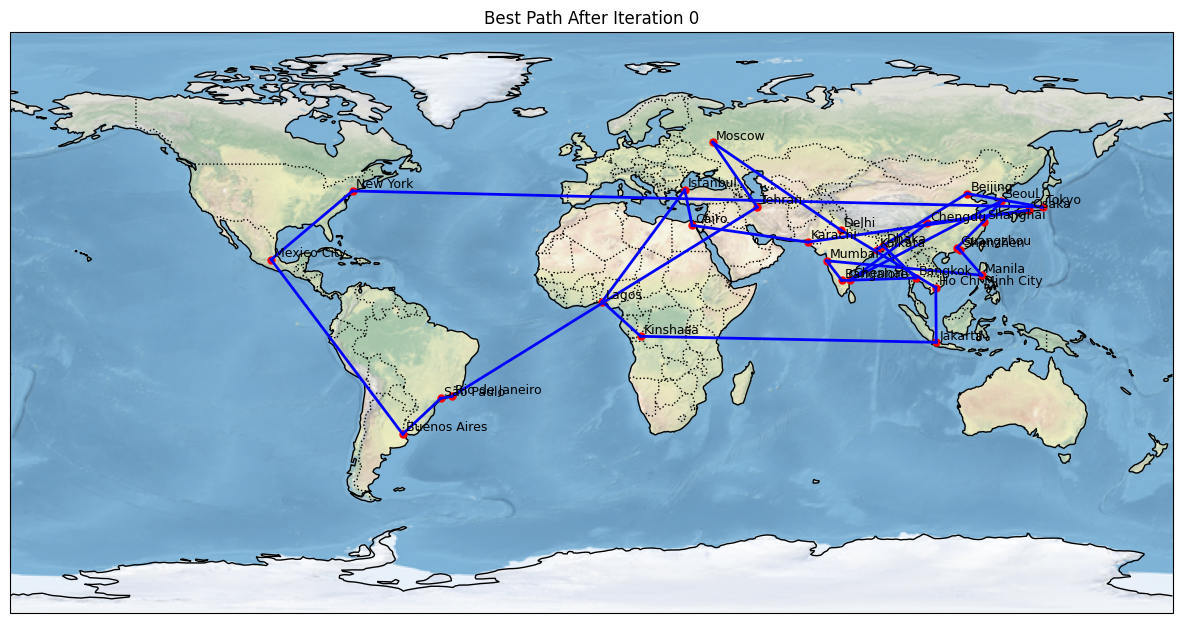

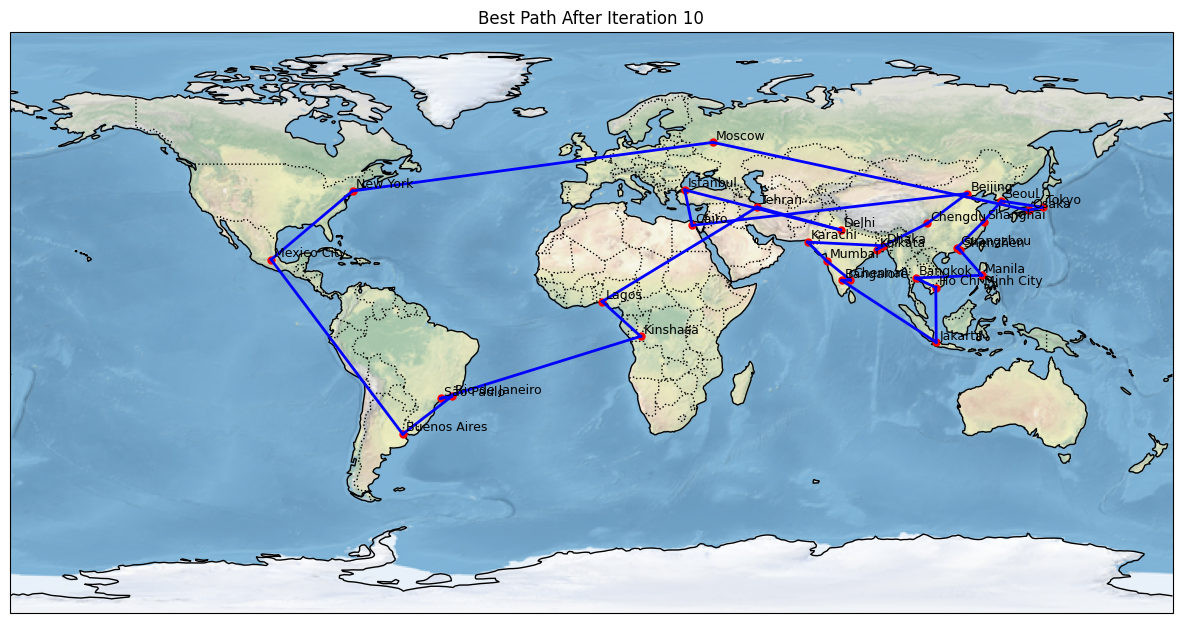

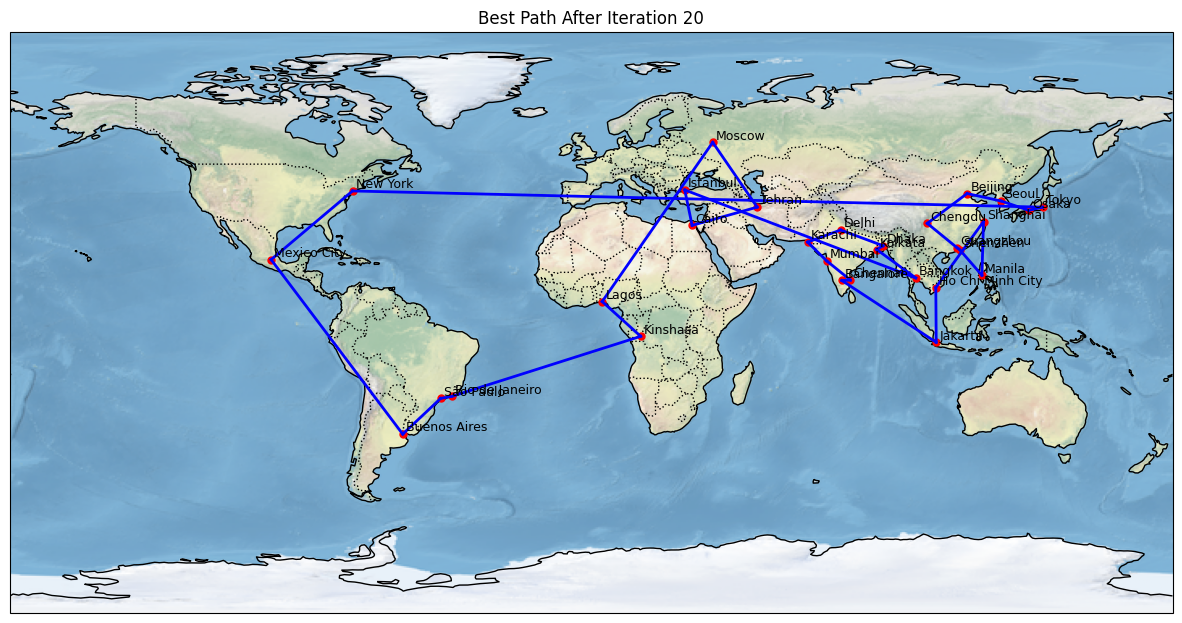

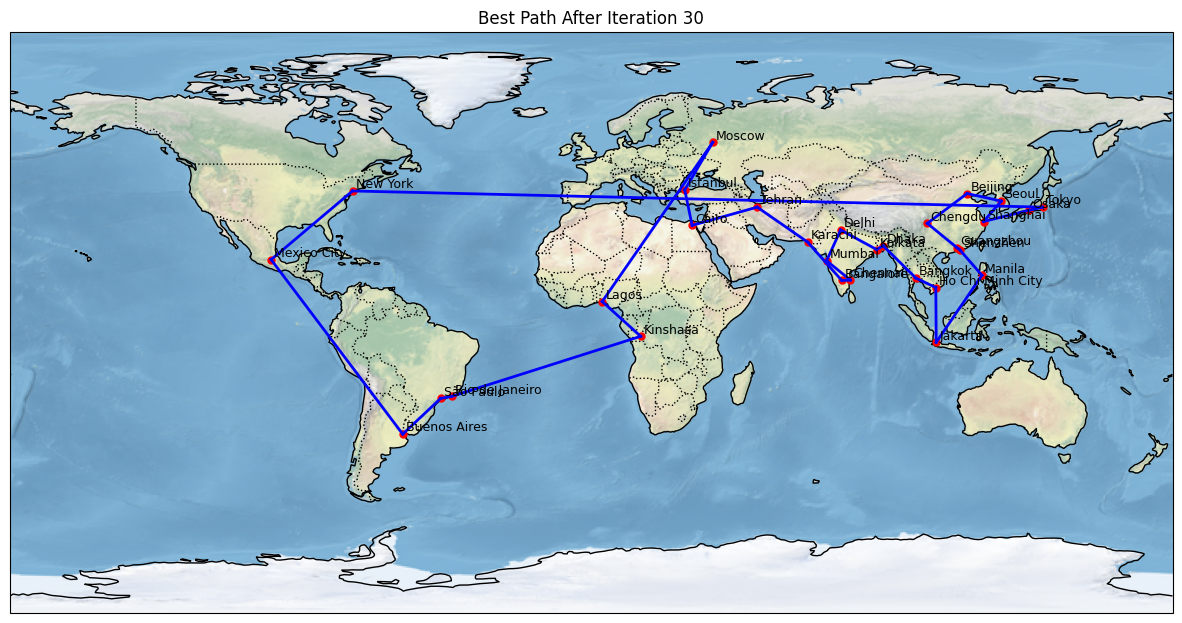

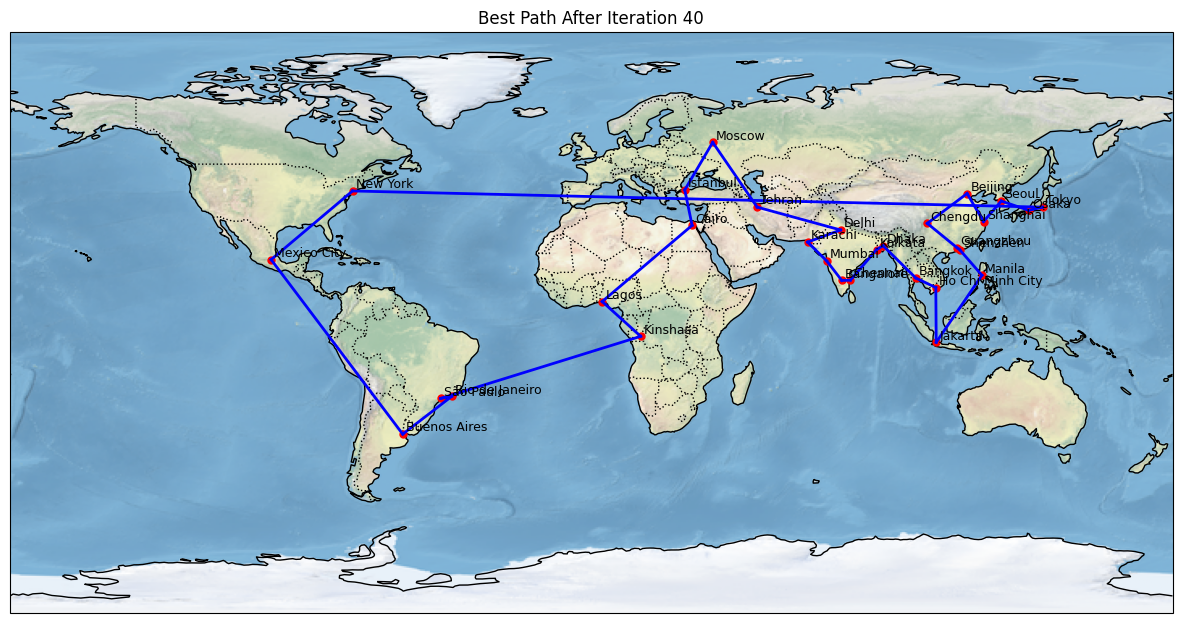

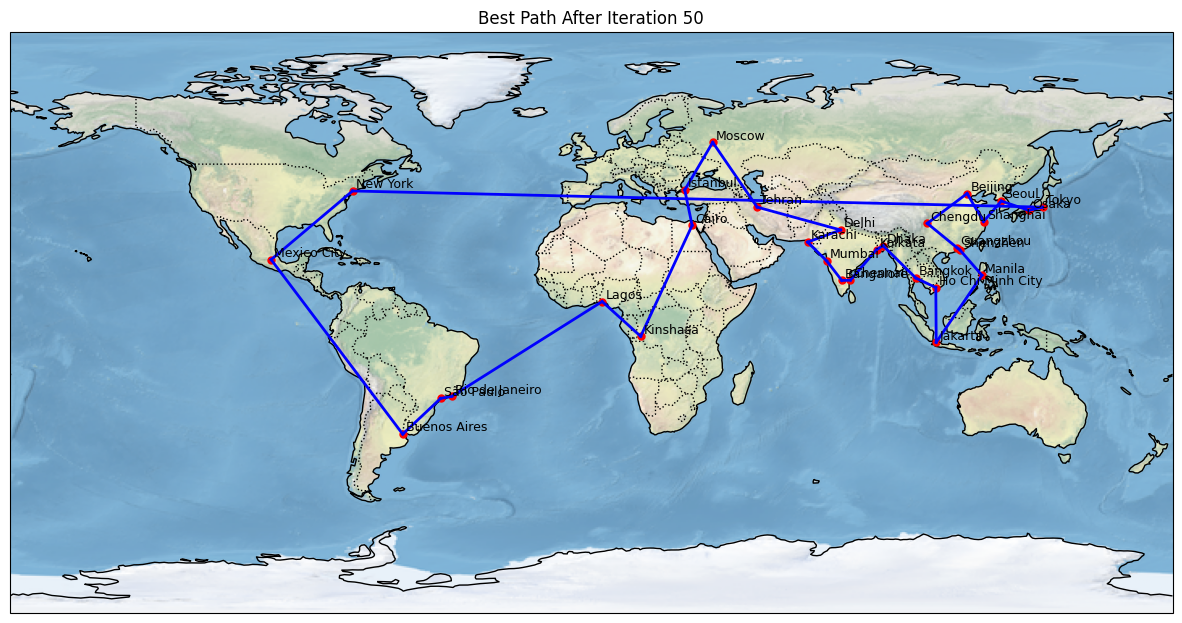

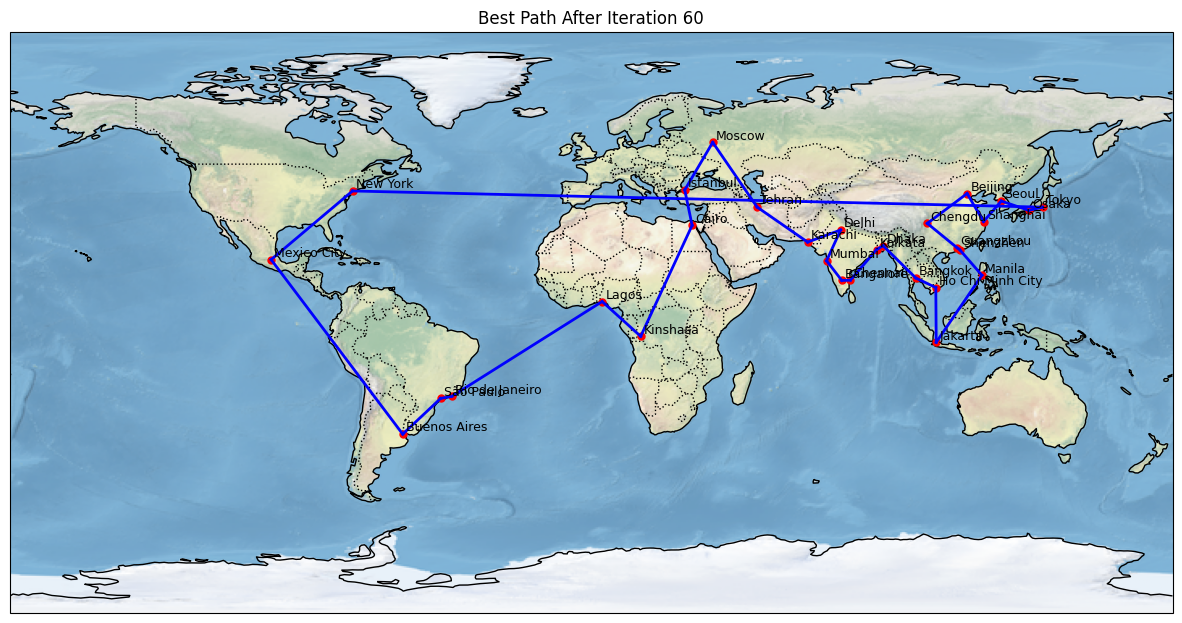

Final best path length: 62116.92829944612
Best path: ['Tokyo', 'Ōsaka', 'Seoul', 'Shanghai', 'Beijing', 'Chengdu', 'Guangzhou', 'Shenzhen', 'Manila', 'Jakarta', 'Ho Chi Minh City', 'Bangkok', 'Dhaka', 'Kolkāta', 'Chennai', 'Bangalore', 'Mumbai', 'Delhi', 'Karachi', 'Tehran', 'Moscow', 'Istanbul', 'Cairo', 'Kinshasa', 'Lagos', 'Rio de Janeiro', 'São Paulo', 'Buenos Aires', 'Mexico City', 'New York']


In [14]:
# Check if the parameters file exists
params_file = 'best_params.json'

# make sure we use the same random seed when running this cell
rng = random.Random(55) 

if os.path.exists(params_file):
    # Load the best parameters from the file
    with open(params_file, 'r') as f:
        best_params = json.load(f)
else:
    # If no previous parameters file, run the optimization first
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    # Save the best parameters after the optimization
    best_params = study.best_params
    with open(params_file, 'w') as f:
        json.dump(best_params, f)

print(f"Best parameters: {best_params}")

# reset graph for evaluation
graph_eval = Graph(cities_list, distance_matrix)

# Run ACO using the best parameters
best_cycle, best_length = ant_colony_optimization(
    graph_eval,
    start_city=start_city,
    q=best_params['q'],
    alpha=best_params['alpha'],
    beta=best_params['beta'],
    iterations=best_params['iterations'],
    ants_per_iteration=best_params['ants'],
    patience=best_params['patience'],
    use_inertia=best_params['use_inertia'], 
    visualize=True,  
    verbose=True,
    rng=rng
)

# Final printout
print("Final best path length:", best_length)
print("Best path:", [graph_eval.idx_to_city[i] for i in best_cycle])